In [22]:



import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# 1. Data Loading

In [3]:
df = pd.read_csv("loan.csv")

In [23]:
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
#shape
df.shape

(614, 13)

# Y Data profiling for EDA

In [5]:
%pip install ydata-profiling


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.6 MB/s eta 0:00:00


In [6]:
# ensure pkg_resources (part of setuptools) is available, and ydata-profiling installed


from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Loan approval", explorative=True)

profile.to_file("ydata.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 24.17it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
len(df.columns)

13

In [8]:
len(df)

614

In [9]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

#2. Data Preprocessing

In [24]:
#Splitting fetaures and target
X = df.drop(['Loan_ID','Loan_Status'], axis=1)

le = LabelEncoder()
y = le.fit_transform(df['Loan_Status'])

#Feature engineering
def feature_engineering(X_df):
  X_df= X_df.copy()
  X_df['Total_Income'] = X_df['ApplicantIncome'] + X_df['CoapplicantIncome']

  return X_df.drop(['ApplicantIncome','CoapplicantIncome'],axis=1)

def log_transform(x):
  return np.log1p(x)

# 3. Pipeline Creation

In [28]:
#Categorical Pipeline
cat_cols= ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Credit_History','Loan_Amount_Term']

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#Numerical pipeline
num_cols = ['Total_Income','LoanAmount']

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transformer', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])
#Combine
preprocessor = ColumnTransformer(
    transformers = [
        ('cat',cat_pipeline,cat_cols),
        ('num',num_pipeline,num_cols)
    ]
)
#Preprocessing pipline
preprocessing_pipeline = Pipeline(steps=[
    ('feat_eng', FunctionTransformer(feature_engineering)), # Apply Feature Engineering first
    ('preprocessor', preprocessor)
])
# full_pipeline = Pipeline(steps=[
#     ('preprocessing', preprocessing_pipeline),
#     ('model', RandomForestClassifier(random_state=42))
# ])


# 4. Primary Model Selection

**Model: Gradient Boosting**


**Justification:**
1. Robustness to Outliers: Financial data, such as Applicant Income and Loan Amount, often contains heavy outliers. Because Gradient Boosting is a tree-based model, it splits data based on thresholds rather than calculating distances, making it significantly less sensitive to outliers than linear models.
2. Handling Mixed Data: This dataset contains a mix of numerical (Income) and categorical (Education, Property Area) features. Gradient Boosting handles these diverse data types effectively without requiring extensive manual feature transformation.
4. Capturing Non-Linearity: Loan approval is rarely a simple linear decision. Gradient Boosting excels at capturing complex, non-linear relationships and interactions between features (e.g., how the impact of Income changes depending on Credit History).
5. Sequential Optimization (Boosting): Unlike Random Forest, which builds trees in parallel and averages them, Gradient Boosting builds trees sequentially. Each new tree specifically focuses on correcting the errors (residuals) made by the previous trees. This iterative refinement allows the model to achieve higher precision and a better F1-score, which is critical for minimizing risky loan approvals.

# 5. Model Training

In [82]:
models_to_train = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}



In [83]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
results = []

# Loop through the dictionary
for name, model in models_to_train.items():


    current_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])

    # Train
    current_pipeline.fit(X_train, y_train)

    # Predict
    y_pred = current_pipeline.predict(X_test)

    # 4. Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Try ROC AUC
    try:
        y_proba = current_pipeline.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        roc_auc = 0.0

    #Store Results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })
results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)
print("\nModel Performance Comparison:")
display(results_df)


Model Performance Comparison:


,Model,Accuracy,F1 Score,ROC AUC
2,Gradient Boosting,0.780488,0.849162,0.724855
1,Random Forest,0.756098,0.833333,0.712064
0,Logistic Regression,0.715447,0.795322,0.717733


In [104]:
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models_to_train[best_model_name]

print(f"Automatically selected the best model: {best_model_name}")
gb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', best_model_obj)
])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the model
gb_pipeline.fit(X_train, y_train)

Automatically selected the best model: Gradient Boosting


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feat_eng',
                                  FunctionTransformer(func=<function feature_engineering at 0x7c914eafee80>)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['Gender',
                                                                    'Married',...
                                                                    'Property_Area',
                                                                    'Credit_History',
                                                                    'Loan_Amount_Term']),
                                                                  ('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log_transformer',
                                                                                    FunctionTransformer(func=<function log_transform at 0x7c914eafe2a0>)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Total_Income',
                                                                    'LoanAmount'])],
                                                    verbose_feature_names_out=False))])),
                ('model', GradientBoostingClassifier(random_state=42))])

# 6. Cross-Validation

In [95]:
# Using 5-fold Cross-Validation
cv_scores = cross_val_score(gb_pipeline, X_train, y_train, cv=5, scoring='accuracy')

print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

CV Accuracy Scores: [0.82828283 0.76530612 0.7244898  0.75510204 0.80612245]
Mean Accuracy: 0.7759
Standard Deviation: 0.0370


# 7. Hyperparameter Tuning

In [96]:
param_grid = {
    'model__n_estimators': [100, 200],      # Number of boosting stages
    'model__learning_rate': [0.01, 0.1, 0.2], # How much each tree contributes
    'model__max_depth': [3, 4, 5]           # Limit depth to prevent overfitting      # Minimum number of samples required to split an internal node
}

# Setup Grid Search
grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit
grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
Best CV Score: 0.8146


# 8. Best Model selection

In [97]:
print("Best Parameters Found:")
print(grid_search.best_params_)

Best Parameters Found:
{'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}


# 9. Model Performance Evaluation

Final Accuracy: 0.7804878048780488
              precision    recall  f1-score   support

           0       0.94      0.40      0.56        43
           1       0.75      0.99      0.85        80

    accuracy                           0.78       123
   macro avg       0.85      0.69      0.71       123
weighted avg       0.82      0.78      0.75       123



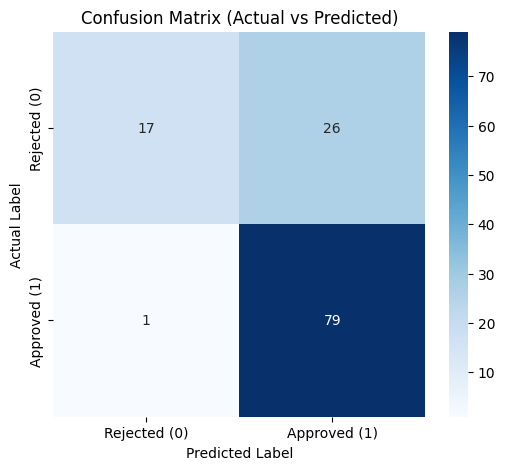

In [109]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 3. Plot Confusion Matrix (Actual vs Predicted)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected (0)', 'Approved (1)'],
            yticklabels=['Rejected (0)', 'Approved (1)'])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Actual vs Predicted)")
plt.show()

In [110]:
import pickle

with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)